# Problem statement 
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [1]:
import pathlib
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

from tensorflow.keras.preprocessing.image import load_img

In [2]:
#mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
#unzip the dataset
!unzip "/content/gdrive/MyDrive/CNN_assignment.zip" > /dev/null

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## train dataset

##  using  seed=123 while creating our dataset using tf.keras.preprocessing.image_dataset_from_directory
## we need to make sure to resize our images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),label_mode='categorical', seed=123, validation_split=0.2,
        subset="training" )

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    image_size=(180,180),
    batch_size=32,
    label_mode='categorical',
    shuffle=True,
    seed=123,
    validation_split=0.2,   # Same split value as before
    subset="validation"     # Subset for validation
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# Listing out all the classes of skin cancer and storing  them in a list.
# We can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### create a code to visualize one instance of all the nine classes present in the dataset

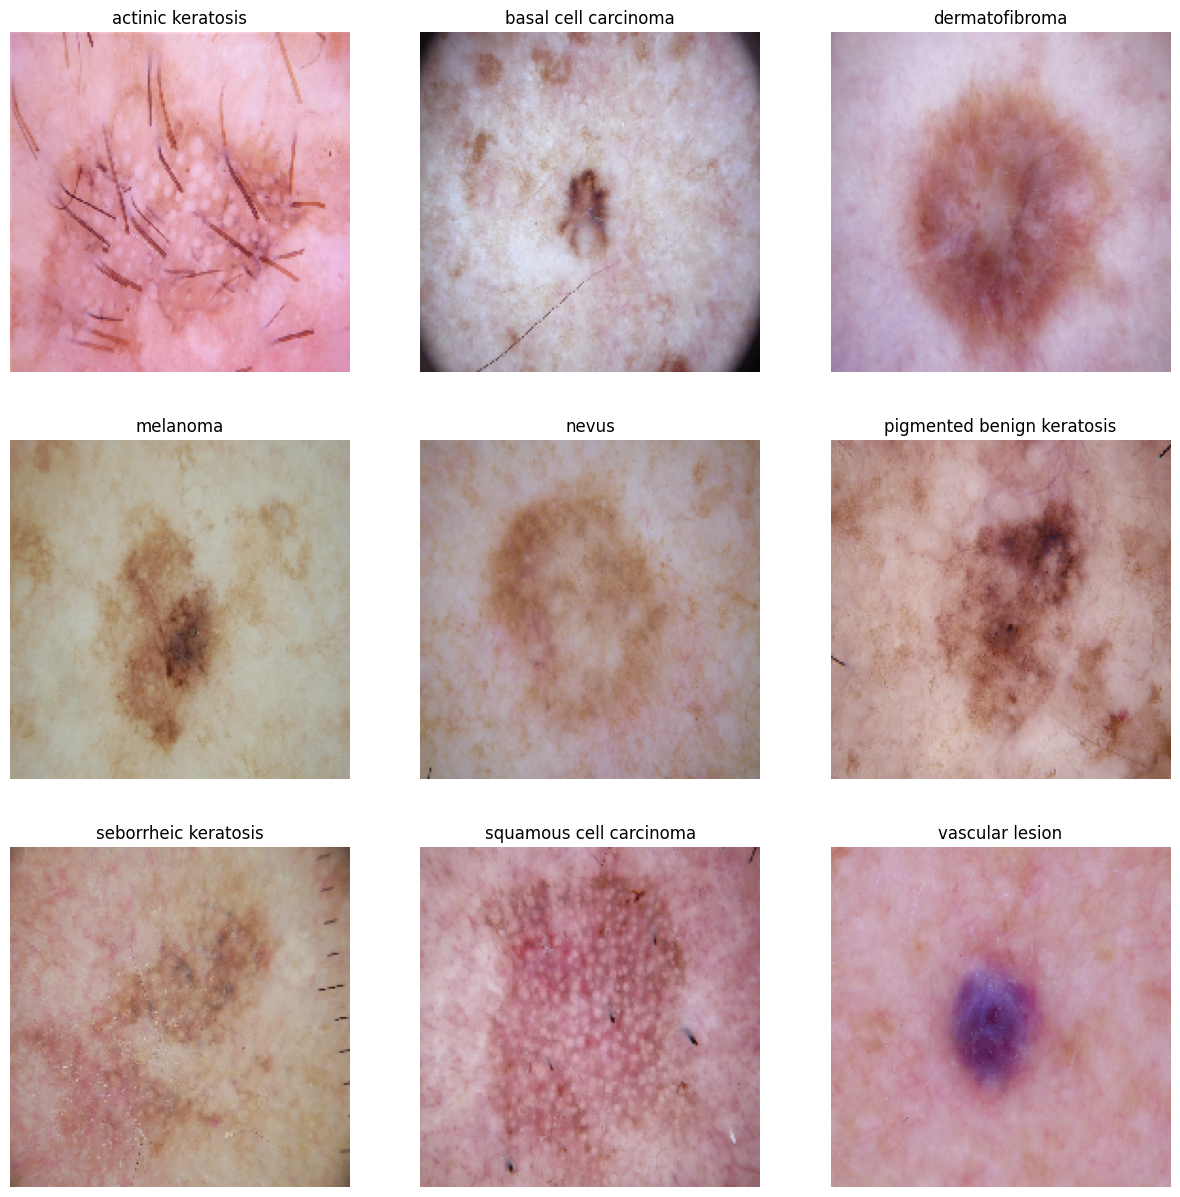

In [10]:
import matplotlib.pyplot as plt


#Dictionary to store the path of image as per the class
files_path_dict = {}

# storing 1 image from each class in the dictionary in Class : Image path format
for c in class_names:
    files_path_dict[c] = list(map(lambda x:   str(data_dir_train)+'/'+c+'/'+x,    os.listdir(str(data_dir_train)+'/'+c      )))

#Visualize image
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    img_path = files_path_dict[c][1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(img_path,target_size=(180,180)))
    plt.title(c)
    plt.axis("off")


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
####  Create a CNN model, which can accurately detect 9 classes present in the dataset. We will use ```layers.Rescaling``` to normalize pixel values between  `[0, 1]`. The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
### Your code goes here
model = Sequential()


#input layer with normalization
model.add(layers.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer and pooling layer(2,2)
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer and pooling layer(2,2)
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer and pooling layer(2,2)
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 20% Fraction of the input units to drop.
model.add(layers.Dropout(0.2))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 30% Fraction of the input units to drop.
model.add(layers.Dropout(0.3))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))



/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [13]:
### choosing  an appropirate optimiser and loss function
# we chose Adam optimizer which is efficient, has adaptive learning rate and helps in fast convergence
# loss function we chose categorical crossentropy since we are doing  multi-class classification
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [15]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 104ms/step - accuracy: 0.1751 - loss: 2.2390 - val_accuracy: 0.2550 - val_loss: 1.9289
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.3524 - loss: 1.8132 - val_accuracy: 0.3982 - val_loss: 1.6570
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.4566 - loss: 1.5068 - val_accuracy: 0.5034 - val_loss: 1.4425
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.4712 - loss: 1.4868 - val_accuracy: 0.5101 - val_loss: 1.4044
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.5022 - loss: 1.4079 - val_accuracy: 0.4877 - val_loss: 1.5971
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.5420 - loss: 1.3382 - val_accuracy: 0.5391 - val_loss: 1.3665
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.5591 - loss: 1.2550 - val_accuracy: 0.5257 - val_loss: 1.3639
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.5827 - loss: 1.1825 - val_accuracy: 0.5391 -

### Visualizing training results

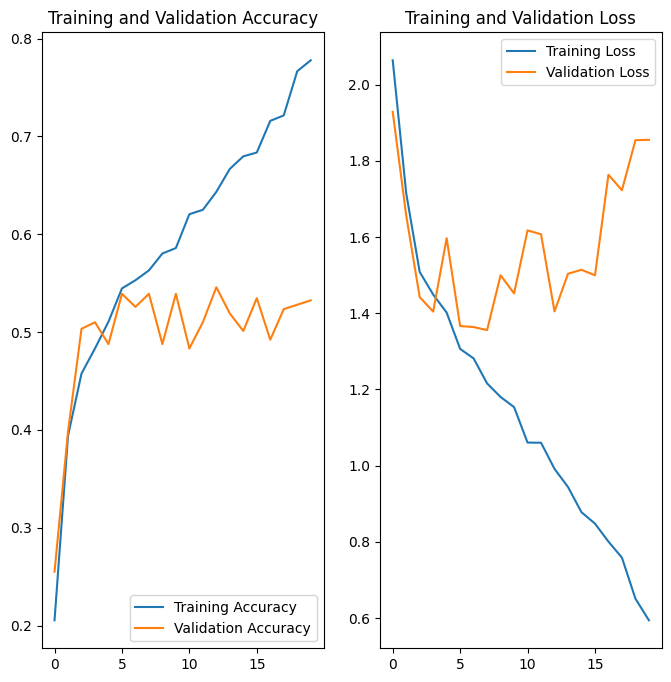

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings after the model fit, and checking if there is an evidence of model overfit or underfit

### Findings:

- We can observe that after a certain number of epochs, training accuracy is increasing but validation accuracy is not. This is a clear indication of overfitting because as the model trains, it learns to fit the training data better and better, but after a certain point, it starts learning noise and irrelevant details from the training data, which doesn't generalize well to unseen validation data.
This results in high training accuracy but stagnant or even decreasing validation accuracy.

- Also we can observe that after a certain number of epochs, training loss is decreasing but validation loss is increasing. This is also due to overfitting as explained above.

In [17]:
# after we  have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Augmentation

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define your data augmentation pipeline
datagen = ImageDataGenerator(
    rotation_range=30,          # Random rotation between 0 and 40 degrees
    width_shift_range=0.2,      # Random horizontal shift
    height_shift_range=0.2,     # Random vertical shift
    shear_range=0.2,            # Shear angle
    zoom_range=0.2,             # Zoom in/out
    horizontal_flip=True,       # Randomly flip images
    fill_mode='nearest'         # Fill pixels with nearest value
)

# Apply data augmentation to the training set
train_ds_aug = datagen.flow_from_directory(
    data_dir_train,
    target_size=(180, 180),      # Resize your images
    batch_size=32,
    class_mode='categorical'
)


Found 2239 images belonging to 9 classes.


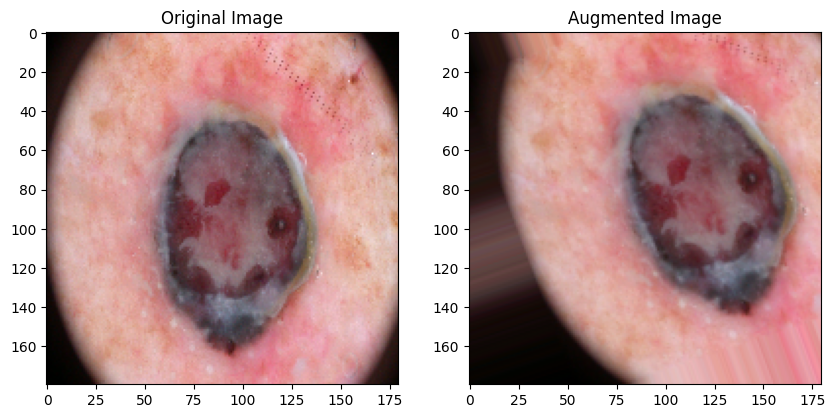

In [18]:
# visualize any one image from any one class and check original vs augmented image


from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

#original img

img_path = '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0000144.jpg'



original_img = load_img(img_path, target_size=(180, 180))



# Convert the image to an array
img_array = img_to_array(original_img)
img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to create a batch of 1 image

# Generate augmented images from this one image
augmented_images = datagen.flow(img_array, batch_size=1)

# Visualize original and augmented images side by side
plt.figure(figsize=(10, 10))

# Plot original image
plt.subplot(1, 2, 1)
plt.imshow(np.uint8(img_array[0]))  # Convert to uint8 to display correctly
plt.title('Original Image')

# Plot augmented image (first augmented image from the generator)
augmented_img = next(augmented_images)[0]  # Get the next augmented image from the generator

plt.subplot(1, 2, 2)
plt.imshow(np.uint8(augmented_img))  # Convert to uint8 to display correctly
plt.title('Augmented Image')

# Show the plot
plt.show()

### Create the model, compile and train the model


In [19]:
### Your code goes here
model = Sequential()


#input layer with normalization
model.add(layers.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer and pooling layer(2,2)
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer and pooling layer(2,2)
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer and pooling layer(2,2)
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 30% Fraction of the input units to drop.
model.add(layers.Dropout(0.2))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.3))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))



/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compiling the model

In [20]:
# compiling 

model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [21]:
## training our model for 20 epochs
history = model.fit(
  train_ds_aug,  # using augmented train set
  validation_data=val_ds,
  epochs=20
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


70/70 ━━━━━━━━━━━━━━━━━━━━ 43s 520ms/step - accuracy: 0.2260 - loss: 2.1394 - val_accuracy: 0.3535 - val_loss: 1.7290
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 76s 458ms/step - accuracy: 0.3911 - loss: 1.6963 - val_accuracy: 0.4295 - val_loss: 1.5912
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 40s 456ms/step - accuracy: 0.3722 - loss: 1.6766 - val_accuracy: 0.4452 - val_loss: 1.5787
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 41s 451ms/step - accuracy: 0.4125 - loss: 1.6490 - val_accuracy: 0.4810 - val_loss: 1.4658
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 34s 436ms/step - accuracy: 0.4316 - loss: 1.5871 - val_accuracy: 0.5078 - val_loss: 1.4353
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 34s 444ms/step - accuracy: 0.4811 - loss: 1.4903 - val_accuracy: 0.5436 - val_loss: 1.3996
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 41s 451ms/step - accuracy: 0.4854 - loss: 1.4722 - val_accuracy: 0.4653 - val_loss: 1.4968
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 34s 440ms/step - accuracy: 0.4855 - loss: 1.4786 - val_accuracy: 0.498

### Visualizing the results

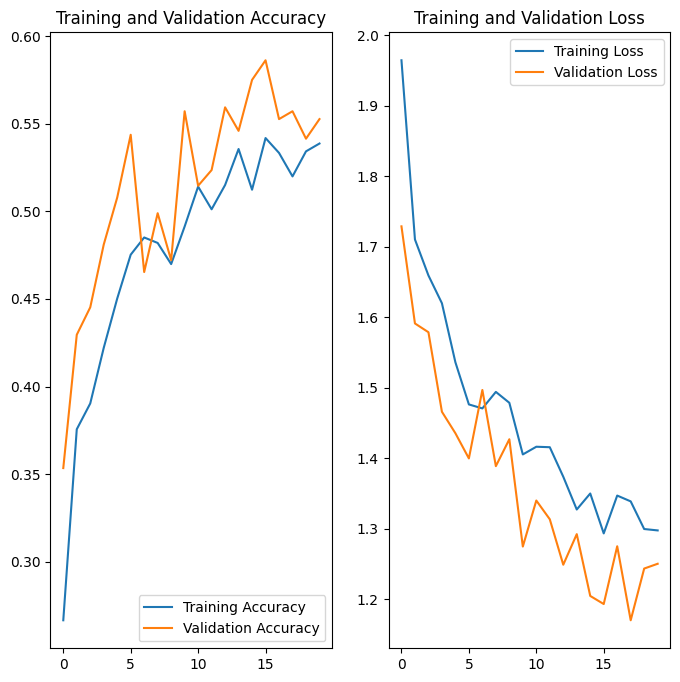

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings:

- After Applying augmentation to images, we can see overfitting slightly reduced because both validation accuracy and validation loss are behaving same as training accuracy and training loss.
- But there are huge spikes of increase/decrease in the graph as observed.
- Also validation accuracy and loss are better than train set. This may happen  because of class imabalance and small dataset.

####  Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [23]:
# storing class name and count of each class in another dictionary using the already created files_path_dict dictionary


count_dic = {key: len(value) for key, value in files_path_dict.items()}
count_dic


{'actinic keratosis': 114,
 'basal cell carcinoma': 376,
 'dermatofibroma': 95,
 'melanoma': 438,
 'nevus': 357,
 'pigmented benign keratosis': 462,
 'seborrheic keratosis': 77,
 'squamous cell carcinoma': 181,
 'vascular lesion': 139}

In [24]:
# converting the dictionary to a pandas dataframe

count_df = pd.DataFrame(list(count_dic.items()), columns=['Class', 'Count'])
count_df

,Class,Count
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


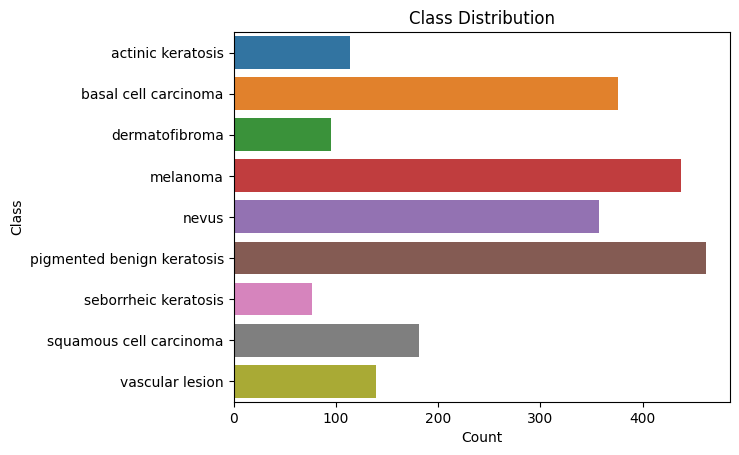

In [25]:
# visualizing the dataframe with seaborn barplot to check class imabalance

import seaborn as sns
sns.barplot(x='Count', y='Class', data=count_df, hue='Class')
plt.xlabel('Count')
plt.ylabel('Class')
plt.title('Class Distribution')
plt.show()

####  FIndings:
#### **Which class has the least number of samples?**
- We can see class **seborrheic keratosis** has least number of samples.

#### **Which classes dominate the data in terms proportionate number of samples?**
- We can observe that class **pigmented benign keratosis** has most number of samples and dominates the data in terms of proportionate number of samples


####  Rectifying  class imbalance
#### **Context:** We can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [26]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [27]:
path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7ECD741EC9A0>: 100%|██████████| 500/500 [00:20<00:00, 23.98 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7ECDFC813EB0>: 100%|██████████| 500/500 [00:19<00:00, 25.89 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7ECD541B3A60>: 100%|██████████| 500/500 [00:15<00:00, 31.70 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7ECD7419E500>: 100%|██████████| 500/500 [01:15<00:00,  6.59 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7ECD54321AB0>: 100%|██████████| 500/500 [01:08<00:00,  7.25 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7ECCE93ADBA0>: 100%|██████████| 500/500 [00:15<00:00, 33.30 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7ECD741EF640>: 100%|██████████| 500/500 [00:35<00:00, 13.97 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7ECD767B60E0>: 100%|██████████| 500/500 [00:14<00:00, 33.80 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7ECD5019EB30>: 100%|██████████| 500/500 [00:15<00:00, 33.05 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [28]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [29]:
import glob
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024494.jpg_d761106d-f5d2-46bd-8470-ac4c0e6509c9.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028258.jpg_41ab2a6a-d182-4925-b0e9-6f1adcd640b3.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025743.jpg_dabbbf71-e271-4179-bee6-67dd51657796.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025286.jpg_fe255941-6caa-4e88-8136-96eb8496380a.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024910.jp

In [30]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmen

In [31]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [32]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([count_df, df2], ignore_index=True)

In [33]:
new_df['Label'].value_counts()

,count
Label,
pigmented benign keratosis,500
dermatofibroma,500
actinic keratosis,500
squamous cell carcinoma,500
seborrheic keratosis,500
nevus,500
basal cell carcinoma,500
melanoma,500
vascular lesion,500


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [34]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [35]:
data_dir_train=data_dir_train
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [36]:
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create your model (make sure to include normalization)

In [37]:
## your code goes here

model = Sequential()

model.add(layers.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 20% Fraction of the input units to drop.
model.add(layers.Dropout(0.2))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 30% Fraction of the input units to drop.
model.add(layers.Dropout(0.3))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

#### Compiling our model (Choose optimizer and loss function appropriately)

In [38]:


model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])



#### **Todo:**  Train your model

In [39]:

## our code goes here, we are using 30 epochs.
history = model.fit(train_ds, validation_data=val_ds, epochs=30)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 35s 187ms/step - accuracy: 0.2045 - loss: 2.1034 - val_accuracy: 0.3875 - val_loss: 1.5967
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 32s 143ms/step - accuracy: 0.4168 - loss: 1.5397 - val_accuracy: 0.4796 - val_loss: 1.3459
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 147ms/step - accuracy: 0.4684 - loss: 1.4031 - val_accuracy: 0.5612 - val_loss: 1.2458
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 26s 150ms/step - accuracy: 0.5222 - loss: 1.2654 - val_accuracy: 0.5457 - val_loss: 1.1768
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 148ms/step - accuracy: 0.5599 - loss: 1.1690 - val_accuracy: 0.6444 - val_loss: 0.9840
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 40s 141ms/step - accuracy: 0.6059 - loss: 1.0387 - val_accuracy: 0.6281 - val_loss: 0.9723
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 47s 175ms/step - accuracy: 0.6545 - loss: 0.9277 - val_accuracy: 0.6370 - val_loss: 0.9772
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 37s 150ms/step - accuracy: 0.6438 - loss: 0

#### **Todo:**  Visualize the model results

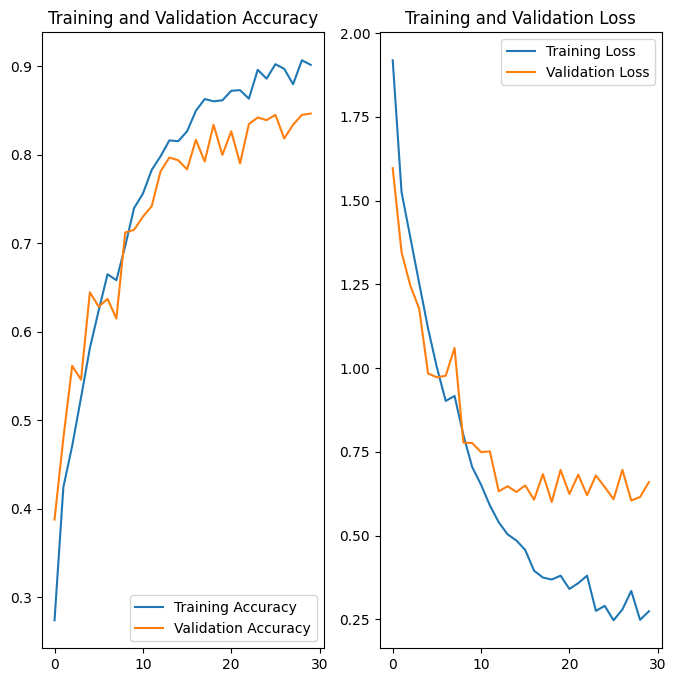

In [41]:
epochs = 30
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

####  Analyzing our results



- We can see that both validation and training accuracy are increasing with  number of epochs 
- Also, both training loss and validation loss are decreasing with number of epochs
- So we can conclude that using augmentator to get rid of class imbalance has clearly improved the problem of overfitting 
- Our model can thus predict unseen data with much more accuracy than before

# Prediction

In [ ]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[4], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[4] +'\n'+ "Predictive Class "+pred_class )